### Loading packages and Read data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helpers import *

In [2]:
df = read_data()

读好数据啦！


In [3]:
# One hot encoding
df_encode = encode(df)

使用了OneHotEncoding，得到：
(745515, 65)


In [4]:
X_train, X_test, y_train, y_test = under_split(df_encode)

在Resampling之后有
没问题的 19104 个
有问题的 4776 个


之前错的方式：如果都 resample

In [ ]:
# df = read_data()
# df_resampled = undersample(df)
# df = encode(df_resampled)

# X = df.drop('fraud_bool',axis=1)
# y = df['fraud_bool']

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

#### KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier

在我的电脑上n_jobs不能用，你们想跑的快一点可以用回来n_jobs

verbose是print东西，verbose=10可以print的非常清楚

In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50), 'weights': ['uniform', 'distance']}

# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train.iloc[:3000], y_train.iloc[:3000])

best_knn_params = grid_search.best_params_
best_knn_estimator = grid_search.best_estimator_

print("Best Hyperparameters:")
print(grid_search.best_params_)

In [ ]:
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(X_train,y_train)
y_knn_pred = best_knn_model.predict(X_test)
y_knn_pred_proba = best_knn_model.predict_proba(X_test)[:, 1]

In [ ]:
cm = confusion_matrix(y_test, y_knn_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_knn_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_knn_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_knn_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_knn_pred))

In [ ]:
auc_related(y_test, y_knn_pred_proba)

#### GBDT

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

因为这里GridSearch用太久，我换成RandomizedSearchCV，结果不会差太多

如果你们电脑可以用n_jobs，那可以把n_iter换大一点，可以得到更好的结果

In [ ]:
gbdt = GradientBoostingClassifier(random_state=42)
param_dist = {
    'n_estimators': range(100, 1000, 50),
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': range(2, 10),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 21),
    'subsample': np.linspace(0.5, 1.0, 6),
    'max_features': ['sqrt', 'log2', None]
}

n_iter = 20

random_search = RandomizedSearchCV(
    gbdt, param_distributions=param_dist, n_iter=n_iter, cv=5,
    scoring='roc_auc', verbose=10, random_state=42
)

random_search.fit(X_train.iloc[:3000], y_train.iloc[:3000])

In [17]:
best_gbdt_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_gbdt_params)

Best Hyperparameters:
{'subsample': 1.0, 'n_estimators': 750, 'min_samples_split': 12, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.021544346900318832}


In [18]:
best_gbdt_model = GradientBoostingClassifier(**best_gbdt_params)
best_gbdt_model.fit(X_train,y_train)
y_gbdt_pred = best_gbdt_model.predict(X_test)
y_gbdt_pred_proba = best_gbdt_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[210836  10712]
 [  1009   1098]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    221548
           1       0.09      0.52      0.16      2107

    accuracy                           0.95    223655
   macro avg       0.54      0.74      0.57    223655
weighted avg       0.99      0.95      0.97    223655


Accuracy Score:
0.9475933916076099


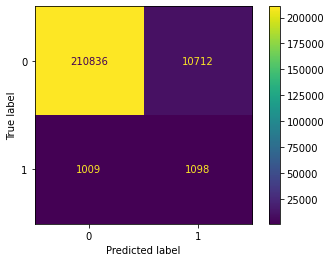

In [19]:
cm = confusion_matrix(y_test, y_gbdt_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_gbdt_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_gbdt_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_gbdt_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_gbdt_pred))

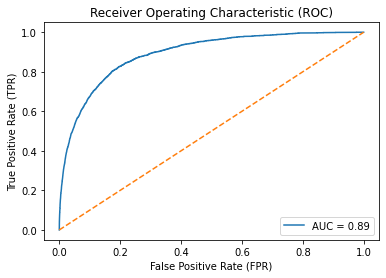

0.8914212567155612

In [22]:
auc_related(y_test,y_gbdt_pred_proba)

#### XGBoost

In [9]:
from xgboost import XGBClassifier

In [10]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
param_dist = {
    'n_estimators': range(100, 1000, 50),
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': range(3, 10),
    'min_child_weight': range(1, 6),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': np.linspace(0, 0.5, 6),
    'reg_alpha': [0, 1e-1, 1, 10, 100],
    'reg_lambda': [0, 1e-1, 1, 10, 100],
    'scale_pos_weight': [1, 2, 3, 4]
}

# n_iter determines the number of random parameter combinations to try
n_iter = 20

random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=n_iter, cv=5,
    scoring='roc_auc', verbose=1, random_state=42
)

random_search.fit(X_train.iloc[:3000], y_train.iloc[:3000])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'max_depth': range(3, 10),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': range(100, 1000, 50),
                                        'reg_alpha': [0, 0.1, 1, 10, 100],
                                        'reg_lambda': [0, 0.1, 1, 10, 100],
                                        'scale_pos_weight': [1, 2, 3, 4],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='roc_auc', verbose=1)

In [11]:
best_xgb_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_xgb_params)

Best Hyperparameters:
{'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 0, 'reg_alpha': 10, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.21544346900318823, 'gamma': 0.0, 'colsample_bytree': 0.9}


In [12]:
best_xgb_model = XGBClassifier(**best_xgb_params)
# best_xgb_model = XGBClassifier()
best_xgb_model.fit(X_train,y_train)
y_xgb_pred = best_xgb_model.predict(X_test)
y_xgb_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[210201  11347]
 [   970   1137]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    221548
           1       0.09      0.54      0.16      2107

    accuracy                           0.94    223655
   macro avg       0.54      0.74      0.56    223655
weighted avg       0.99      0.94      0.96    223655


Accuracy Score:
0.9449285730254187


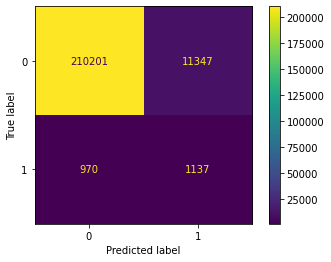

In [13]:
cm = confusion_matrix(y_test, y_xgb_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_xgb_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_xgb_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_xgb_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_xgb_pred))

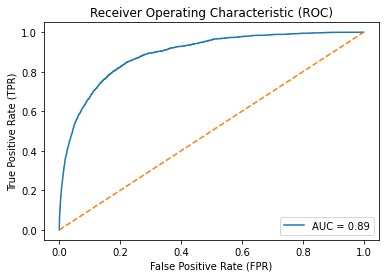

0.8909358770970546

In [15]:
auc_related(y_test, y_xgb_pred_proba)

#### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'batch_size': [32, 64, 128],
    'max_iter': [100, 200, 300],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.01],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.1]
}

mlp_model = MLPClassifier(random_state=42)
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, 
                           scoring='roc_auc', n_jobs=64)
grid_search.fit(X_train[:3000], y_train[:3000])

In [ ]:
best_mlp_params = grid_search.best_params_
print("Best Hyperparameters:")
print(grid_search.best_params_)

In [ ]:
best_mlp_model = MLPClassifier(**best_mlp_params)
best_mlp_model.fit(X_train,y_train)
y_mlp_pred = best_mlp_model.predict(X_test)
y_mlp_pred_proba = best_mlp_model.predict_proba(X_test)[:, 1]

In [ ]:
cm = confusion_matrix(y_test, y_mlp_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_mlp_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_mlp_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_mlp_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_mlp_pred))

In [ ]:
auc_related(y_test, y_mlp_pred)